In [12]:
%matplotlib inline
import requests
from datetime import datetime
from matplotlib import pyplot as plt
from IPython.display import display, HTML
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from numba import guvectorize
from scipy import signal
from scipy import stats as ss

# utils functions
# ===============

def get_prices(coin_symbol):
    """Get close price.

    Given a symbol crytocurrency retrieve last 2k close prices in USD.

    Parameters
    ----------
    coin_symbol : str

    Returns
    -------
    price_close : pandas.DataFrame
    """
    endpoint = "https://min-api.cryptocompare.com/data/histoday"
    params = dict(fsym=coin_symbol, tsym="BTC",limit=2000, aggregate=1)
    out = requests.get(endpoint, params=params,verify=False).json()['Data']
    data = pd.DataFrame(out).set_index('time')\
                            .loc[:, ['close']]\
                            .rename(columns=dict(close=coin_symbol))
    return data


def get_symbol_close(coin_symbol_list):
    """Get symbol close.

    Given a list of cryptocurrencies symbols retrieve close prices.

    Parameters
    ----------
    coin_symbol_list : list

    Returns
    -------
    price_close : pandas.DataFrame
    """
    d = [get_prices(coin_sym) for coin_sym in coin_symbol_list]
    out = pd.concat(d, axis=1)
    out.index = out.index.map(datetime.utcfromtimestamp)
    return out.asfreq(out.index.inferred_freq)


def multi_column_df_display(list_dfs, cols=3):
    html_table = "<table style='width:100%; border:0px'>{content}</table>"
    html_row = "<tr style='border:0px'>{content}</tr>"
    html_cell = "<td style='width:{width}%;vertical-align:top;border:0px'>{{content}}</td>"
    html_cell = html_cell.format(width=100/cols)
    cells = [html_cell.format(content=df.to_html()) for df in list_dfs]
    cells += (cols - (len(list_dfs) % cols)) * [html_cell.format(content="")]
    rows = [html_row.format(content="".join(cells[i:i+cols])) for i in range(0, len(cells), cols)]
    display(HTML(html_table.format(content="".join(rows))))

# hurst functions
# ===============
@guvectorize("float64[:], int64, int64, int64, float64[:]", "(m),(),(),()->()",
             cache=True, nopython=True)
def hurst_rs(x, min_chunksize, max_chunksize, num_chunksize, out):
    """Estimate the Hurst exponent using R/S method.

    Estimates the Hurst (H) exponent using the R/S method from the time series.
    The R/S method consists of dividing the series into pieces of equal size
    `series_len` and calculating the rescaled range. This repeats the process
    for several `series_len` values and adjusts data regression to obtain the H.
    `series_len` will take values between `min_chunksize` and `max_chunksize`,
    the step size from `min_chunksize` to `max_chunksize` can be controlled
    through the parameter `step_chunksize`.

    Parameters
    ----------
    x : 1D-array
        A time series to calculate hurst exponent, must have more elements
        than `min_chunksize` and `max_chunksize`.
    min_chunksize : int
        This parameter allow you control the minimum window size.
    max_chunksize : int
        This parameter allow you control the maximum window size.
    num_chunksize : int
        This parameter allow you control the size of the step from minimum to
        maximum window size. Bigger step means fewer calculations.
    out : 1-element-array, optional
        one element array to store the output.

    Returns
    -------
    H : float
        A estimation of Hurst exponent.

    References
    ----------
    Hurst, H. E. (1951). Long term storage capacity of reservoirs. ASCE
    Transactions, 116(776), 770-808.
    Alessio, E., Carbone, A., Castelli, G. et al. Eur. Phys. J. B (2002) 27:
    197. http://dx.doi.org/10.1140/epjb/e20020150
    """
    N = len(x)
    max_chunksize += 1
    rs_tmp = np.empty(N, dtype=np.float64)
    chunk_size_list = np.linspace(min_chunksize, max_chunksize, num_chunksize)\
                        .astype(np.int64)
    rs_values_list = np.empty(num_chunksize, dtype=np.float64)

    # 1. The series is divided into chunks of chunk_size_list size
    for i in range(num_chunksize):
        chunk_size = chunk_size_list[i]

        # 2. it iterates on the indices of the first observation of each chunk
        number_of_chunks = int(len(x) / chunk_size)

        for idx in range(number_of_chunks):
            # next means no overlapping
            # convert index to index selection of each chunk
            ini = idx * chunk_size
            end = ini + chunk_size
            chunk = x[ini:end]

            # 2.1 Calculate the RS (chunk_size)
            z = np.cumsum(chunk - np.mean(chunk))
            rs_tmp[idx] = np.divide(
                np.max(z) - np.min(z),  # range
                np.nanstd(chunk)  # standar deviation
            )

        # 3. Average of RS(chunk_size)
        rs_values_list[i] = np.nanmean(rs_tmp[:idx + 1])

    # 4. calculate the Hurst exponent.
    H, c = np.linalg.lstsq(
        a=np.vstack((np.log(chunk_size_list), np.ones(num_chunksize))).T,
        b=np.log(rs_values_list)
    )[0]

    out[0] = H


def hurst_dma(prices, min_chunksize=8, max_chunksize=200, num_chunksize=5):
    """Estimate the Hurst exponent using R/S method.

    Estimates the Hurst (H) exponent using the DMA method from the time series.
    The DMA method consists on calculate the moving average of size `series_len`
    and subtract it to the original series and calculating the standard
    deviation of that result. This repeats the process for several `series_len`
    values and adjusts data regression to obtain the H. `series_len` will take
    values between `min_chunksize` and `max_chunksize`, the step size from
    `min_chunksize` to `max_chunksize` can be controlled through the parameter
    `step_chunksize`.

    Parameters
    ----------
    prices
    min_chunksize
    max_chunksize
    num_chunksize

    Returns
    -------
    hurst_exponent : float
        Estimation of hurst exponent.

    References
    ----------
    Alessio, E., Carbone, A., Castelli, G. et al. Eur. Phys. J. B (2002) 27:
    197. http://dx.doi.org/10.1140/epjb/e20020150

    """
    max_chunksize += 1
    N = len(prices)
    n_list = np.arange(min_chunksize, max_chunksize, num_chunksize, dtype=np.int64)
    dma_list = np.empty(len(n_list))
    factor = 1 / (N - max_chunksize)
    # sweeping n_list
    for i, n in enumerate(n_list):
        b = np.divide([n - 1] + (n - 1) * [-1], n)  # do the same as:  y - y_ma_n
        noise = np.power(signal.lfilter(b, 1, prices)[max_chunksize:], 2)
        dma_list[i] = np.sqrt(factor * np.sum(noise))

    H, const = np.linalg.lstsq(
        a=np.vstack([np.log10(n_list), np.ones(len(n_list))]).T,
        b=np.log10(dma_list)
    )[0]
    return H


def hurst_dsod(x):
    """Estimate Hurst exponent on data timeseries.

    The estimation is based on the discrete second order derivative. Consists on
    get two different noise of the original series and calculate the standard
    deviation and calculate the slope of two point with that values.
    source: https://gist.github.com/wmvanvliet/d883c3fe1402c7ced6fc

    Parameters
    ----------
    x : numpy array
        time series to estimate the Hurst exponent for.

    Returns
    -------
    h : float
        The estimation of the Hurst exponent for the given time series.

    References
    ----------
    Istas, J.; G. Lang (1994), “Quadratic variations and estimation of the local
    Hölder index of data Gaussian process,” Ann. Inst. Poincaré, 33, pp. 407–436.


    Notes
    -----
    This hurst_ets is data literal traduction of wfbmesti.m of waveleet toolbox
    from matlab.
    """
    y = np.cumsum(np.diff(x, axis=0), axis=0)

    # second order derivative
    b1 = [1, -2, 1]
    y1 = signal.lfilter(b1, 1, y, axis=0)
    y1 = y1[len(b1) - 1:]  # first values contain filter artifacts

    # wider second order derivative
    b2 = [1,  0, -2, 0, 1]
    y2 = signal.lfilter(b2, 1, y, axis=0)
    y2 = y2[len(b2) - 1:]  # first values contain filter artifacts

    s1 = np.mean(y1 ** 2, axis=0)
    s2 = np.mean(y2 ** 2, axis=0)

    return 0.5 * np.log2(s2 / s1)


def hurst_exponent(prices, min_chunksize=8, max_chunksize=200, num_chunksize=5,
                   method='RS'):
    """Estimates Hurst Exponent.

    Estimate the hurst exponent following one of 3 methods. Each method

    Parameters
    ----------
    prices : numpy.ndarray, pandas.Series or pandas.DataFrame
        A time series to estimate hurst exponent.
    min_chunksize : int, optional
        Minimum chunk  size of the original series. This parameter doesn't have
        any effect with DSOD method.
    max_chunksize : int, optional
        Maximum chunk size of the original series. This parameter doesn't have
        any effect with DSOD method.
    step_chunksize : int, optional
        Step used to select next the chunk size which divide the original
        series. This parameter doesn't have any effect with DSOD method.
    method : {'RS', 'DMA', 'DSOD', 'all'}
        The methods can take one of that values,
            RS : rescaled range.
            DMA : deviation moving average.
            DSOD : discrete second order derivative.


    Returns
    -------
    hurst_exponent : float
        Estimation of hurst_exponent according to the method selected.

    References
    ----------
    RS : Hurst, H. E. (1951). Long term storage capacity of reservoirs. ASCE
         Transactions, 116(776), 770-808.
    DMA : Alessio, E., Carbone, A., Castelli, G. et al. Eur. Phys. J. B (2002)
         27: 197. http://dx.doi.org/10.1140/epjb/e20020150
    DSOD : Istas, J.; G. Lang (1994), “Quadratic variations and estimation of
        the local Hölder index of data Gaussian process,” Ann. Inst. Poincaré,
        33, pp. 407–436.

    Notes
    -----
    The hurst exponent is an estimation which is important because there is no
    data closed equation for it instead we have some methods to estimate it with
    high variations among them.

    See Also
    --------
    hurst_rs, hurst_dma, hurst_dsod
    """
    if len(prices) == 0:
        return np.nan
    # extract array
    arr = prices.__array__()
    # choose data method
    if method == 'RS':
        if prices.ndim > 1:
            h = hurst_rs(np.diff(arr, axis=0).T, min_chunksize, max_chunksize,
                         num_chunksize)
        else:
            h = hurst_rs(np.diff(arr), min_chunksize, max_chunksize,
                         num_chunksize)
    elif method == 'DMA':
        h = hurst_dma(arr, min_chunksize, max_chunksize, num_chunksize)
    elif method == 'DSOD':
        h = hurst_dsod(arr)
    elif method == 'all':
        return [
            hurst_exponent(arr, min_chunksize, max_chunksize, num_chunksize, 'RS'),
            hurst_exponent(arr, min_chunksize, max_chunksize, num_chunksize, 'DMA'),
            hurst_exponent(arr, min_chunksize, max_chunksize, num_chunksize, 'DSOD')
        ]
    else:
        raise NotImplementedError('The method choose is not implemented.')
    
    return h

To show about about persistence we can follow similiar steps as shown in the paper [Persistence in the cryptocurrency market](https://www.sciencedirect.com/science/article/pii/S0275531917309200). I select the same four currencies selected in that paper, that is: Bitcoin, Ethereum, Dash and Litecoin.

You can see [here](https://coinmarketcap.com/coins/) the top crypto currencies by market capitalization.

In [13]:
coin_sym_list = 'ETH DASH LTC'.split()
prices = get_symbol_close(coin_sym_list)
prices = prices.loc['2014':'2017']  # select the same period
prices = prices.where(prices != 0., np.nan)  # convert zeros into NaN's

/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py:858: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py:858: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py:858: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


In [14]:
multi_column_df_display([prices.head(), prices.tail()], 2)

,ETH,DASH,LTC
time,,,
2014-01-01,NaN,NaN,0.0320
2014-01-02,NaN,NaN,0.0323
2014-01-03,NaN,NaN,0.0304
2014-01-04,NaN,NaN,0.0298
2014-01-05,NaN,NaN,0.0293
,ETH,DASH,LTC
time,,,
2017-12-27,0.04790,0.07361,0.01707
2017-12-28,0.04989,0.07700,0.01728


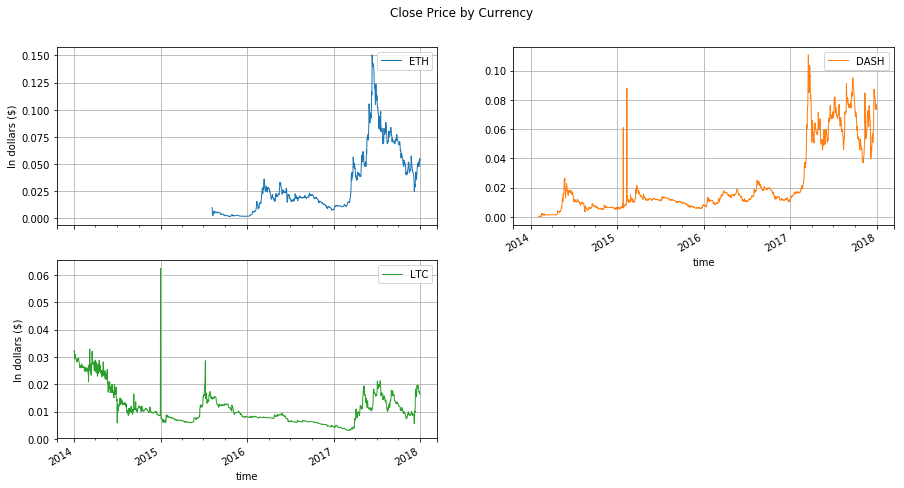

In [15]:
# plot price series
kw = dict(figsize=(15,8), grid=True, subplots=True, layout=(2,2), linewidth=1)
axs = prices.plot(**kw)
[ax.set_ylabel('In dollars ($)') for ax in axs.flat[::2]]
plt.suptitle('Close Price by Currency', y=0.95);

In [16]:
# table hurst with entire series
hurst_methods = [
    prices.apply(lambda x: hurst_exponent(x.dropna(), method='DSOD')),
    prices.apply(lambda x: hurst_exponent(x.dropna(), method='RS')),
    prices.apply(lambda x: hurst_exponent(x.dropna(), method='DMA')),
]
hurst_table = pd.concat(hurst_methods, axis=1)
hurst_table.columns = ['DSOD', 'RS', 'DMA']
hurst_table

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:189: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


,DSOD,RS,DMA
ETH,0.431509,0.607785,0.520548
DASH,0.170188,0.578141,0.297084
LTC,0.080529,0.537747,0.319900


In [17]:
# the same methodology as shown in the paper.
roll_days = 250
roll_prices = prices.rolling(roll_days)
summary = [
    roll_prices.apply(lambda s: hurst_exponent(s, method='RS')),
    roll_prices.apply(lambda s: hurst_exponent(s, method='DSOD')),
    ]
roll_hurst = pd.concat(summary, axis=1, keys=['RS', 'DSOD'])
roll_hurst = roll_hurst.swaplevel(axis=1)\
                       .asfreq(roll_hurst.index.inferred_freq)\
                       .sort_index(axis=1, level=0)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  """
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  


In [18]:
roll_hurst[::50].tail()

DASH                 ETH                 LTC          
                DSOD        RS      DSOD        RS      DSOD        RS
time                                                                  
2017-06-04  0.705865  0.681638  0.522301  0.674941  0.442743  0.561282
2017-07-24  0.679774  0.682172  0.386203  0.635312  0.452781  0.631437
2017-09-12  0.628351  0.628258  0.384286  0.612318  0.457661  0.583448
2017-11-01  0.633560  0.650677  0.380865  0.624193  0.457424  0.537978
2017-12-21  0.457909  0.561385  0.416898  0.646611  0.610649  0.523105

In [19]:
roll_hurst[::50].mean()

DASH  DSOD    0.411756
      RS      0.563451
ETH   DSOD    0.471022
      RS      0.609500
LTC   DSOD    0.320595
      RS      0.532311
dtype: float64

In [20]:
roll_hurst[::50].median()

DASH  DSOD    0.495542
      RS      0.568277
ETH   DSOD    0.479287
      RS      0.624193
LTC   DSOD    0.397846
      RS      0.523105
dtype: float64

In [21]:
roll_hurst[::50].mean(level=0, axis=1);

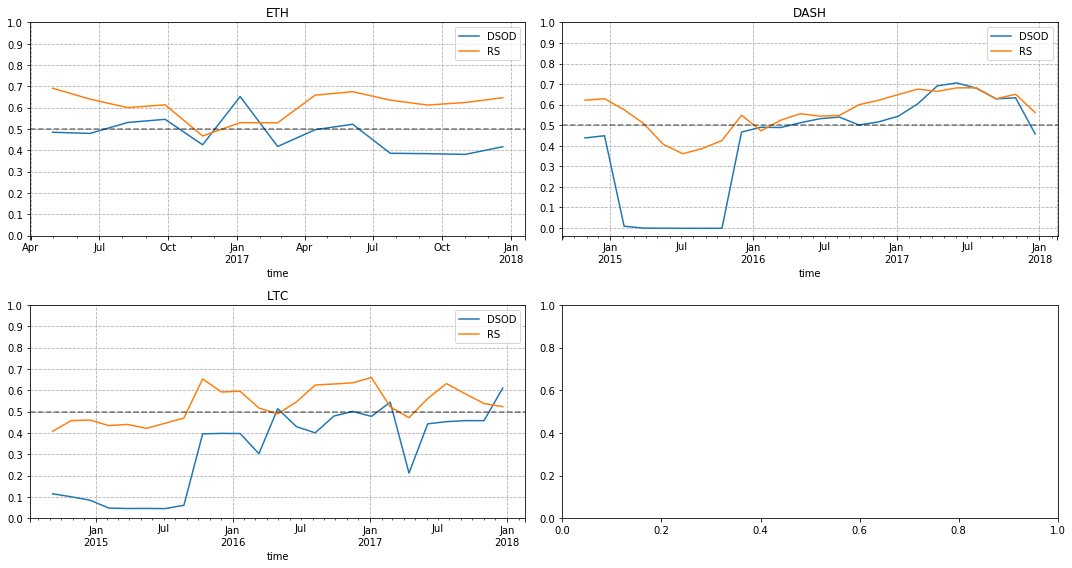

In [22]:
fig, axs = plt.subplots(2,2, figsize=(15,8))
for ax, coin in zip(axs.flat, coin_sym_list):
    roll_hurst[coin][::50].plot(ax=ax)
    ax.set_title(coin)
    ax.set_yticks(np.arange(11)/10)
    ax.grid(True, linestyle='--')
    ax.axhline(0.5, linestyle='--', color='k', alpha=0.5)
fig.tight_layout()

In [23]:
# rather decimate the series we aliasing the seies.
ma_roll_hurst = roll_hurst.rolling(50).mean()
ma_roll_hurst.tail()

DASH                 ETH                 LTC          
                DSOD        RS      DSOD        RS      DSOD        RS
time                                                                  
2017-12-27  0.491340  0.556136  0.388221  0.635379  0.499741  0.542875
2017-12-28  0.488806  0.554158  0.388904  0.635715  0.502427  0.542388
2017-12-29  0.486271  0.552088  0.389562  0.636325  0.505160  0.541883
2017-12-30  0.483738  0.550253  0.390223  0.636929  0.507841  0.541581
2017-12-31  0.481245  0.547778  0.390833  0.636929  0.510512  0.541414

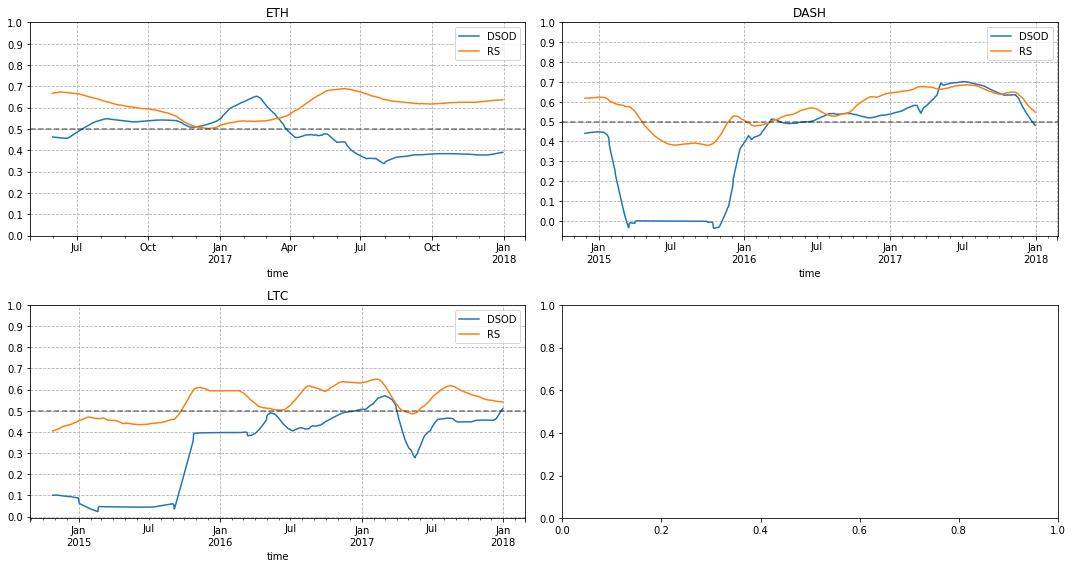

In [24]:
fig, axs = plt.subplots(2,2, figsize=(15,8))
for ax, coin in zip(axs.flat, coin_sym_list):
    roll_hurst[coin].rolling(50).mean().plot(ax=ax)
    ax.set_title(coin)
    ax.set_yticks(np.arange(11)/10)
    ax.grid(True, linestyle='--')
    ax.axhline(0.5, linestyle='--', color='k', alpha=0.5)
fig.tight_layout()

In [25]:
roll_hurst[::30].tail()

DASH                 ETH                 LTC          
                DSOD        RS      DSOD        RS      DSOD        RS
time                                                                  
2017-08-13  0.680391  0.643112  0.376744  0.632824  0.457041  0.610358
2017-09-12  0.628351  0.628258  0.384286  0.612318  0.457661  0.583448
2017-10-12  0.634568  0.661480  0.387381  0.626255  0.456474  0.555720
2017-11-11  0.635222  0.629392  0.379652  0.646178  0.456577  0.526978
2017-12-11  0.494765  0.529578  0.391933  0.640876  0.492454  0.541952

In [26]:
roll_hurst[::30].mean()

DASH  DSOD    0.406217
      RS      0.558772
ETH   DSOD    0.467383
      RS      0.606895
LTC   DSOD    0.328598
      RS      0.537331
dtype: float64

In [27]:
roll_hurst[::30].median()

DASH  DSOD    0.494765
      RS      0.570424
ETH   DSOD    0.467643
      RS      0.618644
LTC   DSOD    0.398588
      RS      0.549167
dtype: float64

In [28]:
roll_hurst[::30].mean(level=0, axis=1);

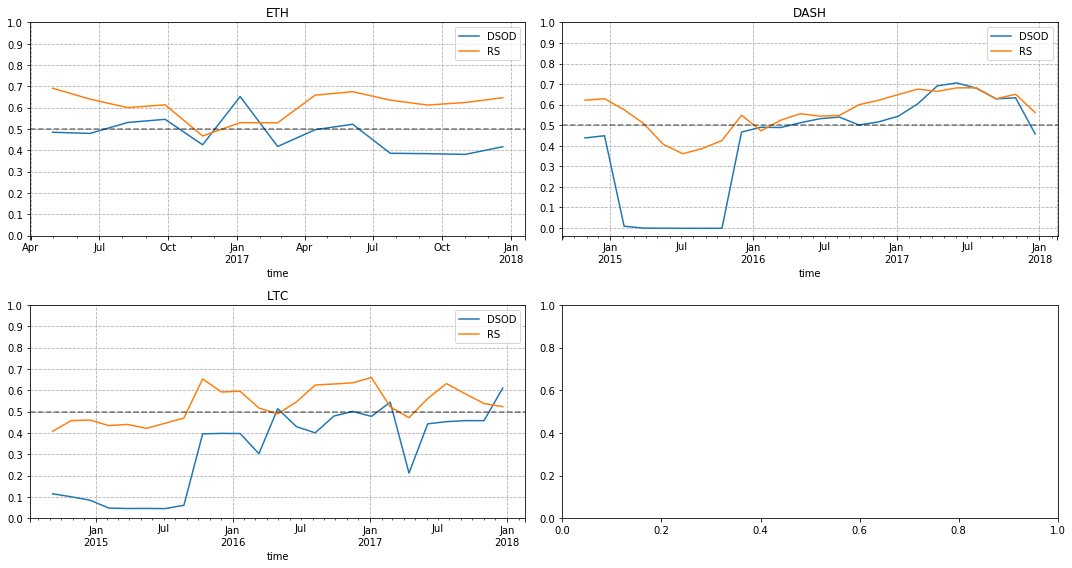

In [29]:
fig, axs = plt.subplots(2,2, figsize=(15,8))
for ax, coin in zip(axs.flat, coin_sym_list):
    roll_hurst[coin][::50].plot(ax=ax)
    ax.set_title(coin)
    ax.set_yticks(np.arange(11)/10)
    ax.grid(True, linestyle='--')
    ax.axhline(0.5, linestyle='--', color='k', alpha=0.5)
fig.tight_layout()

In [30]:
# rather decimate the series we aliasing the seies.
ma_roll_hurst = roll_hurst.rolling(30).mean()
ma_roll_hurst.tail()

DASH                 ETH                 LTC          
                DSOD        RS      DSOD        RS      DSOD        RS
time                                                                  
2017-12-27  0.479726  0.542356  0.397408  0.640376  0.529276  0.544748
2017-12-28  0.482612  0.540479  0.398546  0.639769  0.533933  0.543115
2017-12-29  0.485207  0.539504  0.399693  0.639787  0.538722  0.541717
2017-12-30  0.486455  0.537875  0.400822  0.640201  0.543807  0.540519
2017-12-31  0.488244  0.536530  0.401891  0.640512  0.548952  0.538989

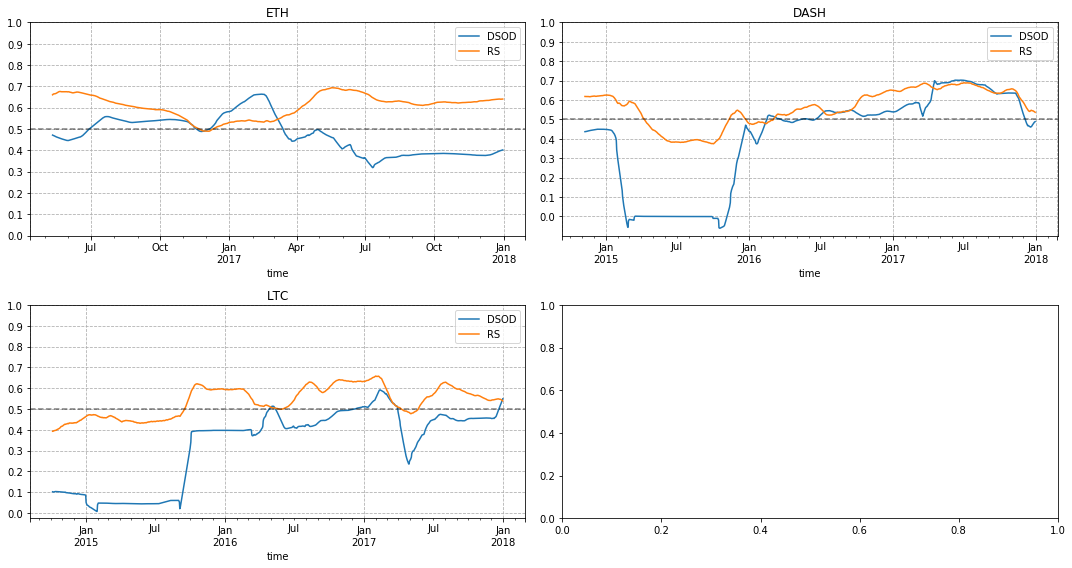

In [31]:
fig, axs = plt.subplots(2,2, figsize=(15,8))
for ax, coin in zip(axs.flat, coin_sym_list):
    roll_hurst[coin].rolling(30).mean().plot(ax=ax)
    ax.set_title(coin)
    ax.set_yticks(np.arange(11)/10)
    ax.grid(True, linestyle='--')
    ax.axhline(0.5, linestyle='--', color='k', alpha=0.5)
fig.tight_layout()

In [32]:
roll_hurst[::20].tail()

DASH                 ETH                 LTC          
                DSOD        RS      DSOD        RS      DSOD        RS
time                                                                  
2017-10-12  0.634568  0.661480  0.387381  0.626255  0.456474  0.555720
2017-11-01  0.633560  0.650677  0.380865  0.624193  0.457424  0.537978
2017-11-21  0.449091  0.511541  0.375634  0.639584  0.454159  0.543536
2017-12-11  0.494765  0.529578  0.391933  0.640876  0.492454  0.541952
2017-12-31  0.510587  0.505634  0.410169  0.646168  0.590117  0.518657

In [33]:
roll_hurst[::20].mean()

DASH  DSOD    0.413696
      RS      0.560895
ETH   DSOD    0.467161
      RS      0.610315
LTC   DSOD    0.331683
      RS      0.534142
dtype: float64

In [34]:
roll_hurst[::20].median()

DASH  DSOD    0.500892
      RS      0.555353
ETH   DSOD    0.475651
      RS      0.628869
LTC   DSOD    0.399568
      RS      0.543536
dtype: float64

In [35]:
roll_hurst[::20].mean(level=0, axis=1);

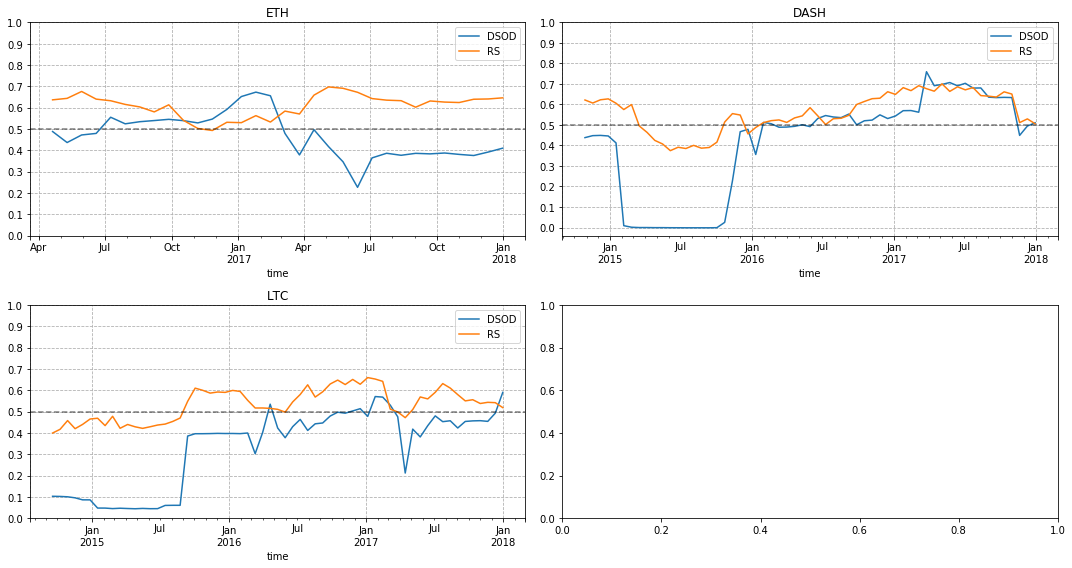

In [36]:
fig, axs = plt.subplots(2,2, figsize=(15,8))
for ax, coin in zip(axs.flat, coin_sym_list):
    roll_hurst[coin][::20].plot(ax=ax)
    ax.set_title(coin)
    ax.set_yticks(np.arange(11)/10)
    ax.grid(True, linestyle='--')
    ax.axhline(0.5, linestyle='--', color='k', alpha=0.5)
fig.tight_layout()

In [37]:
# rather decimate the series we aliasing the seies.
ma_roll_hurst = roll_hurst.rolling(20).mean()
ma_roll_hurst.tail()

DASH                 ETH                 LTC          
                DSOD        RS      DSOD        RS      DSOD        RS
time                                                                  
2017-12-27  0.490488  0.540662  0.406627  0.638685  0.566129  0.541127
2017-12-28  0.494274  0.541596  0.408503  0.638940  0.574472  0.539116
2017-12-29  0.495338  0.542041  0.409530  0.640231  0.577958  0.536865
2017-12-30  0.496203  0.541028  0.410674  0.641120  0.582150  0.535789
2017-12-31  0.496994  0.539831  0.411586  0.641385  0.587033  0.534625

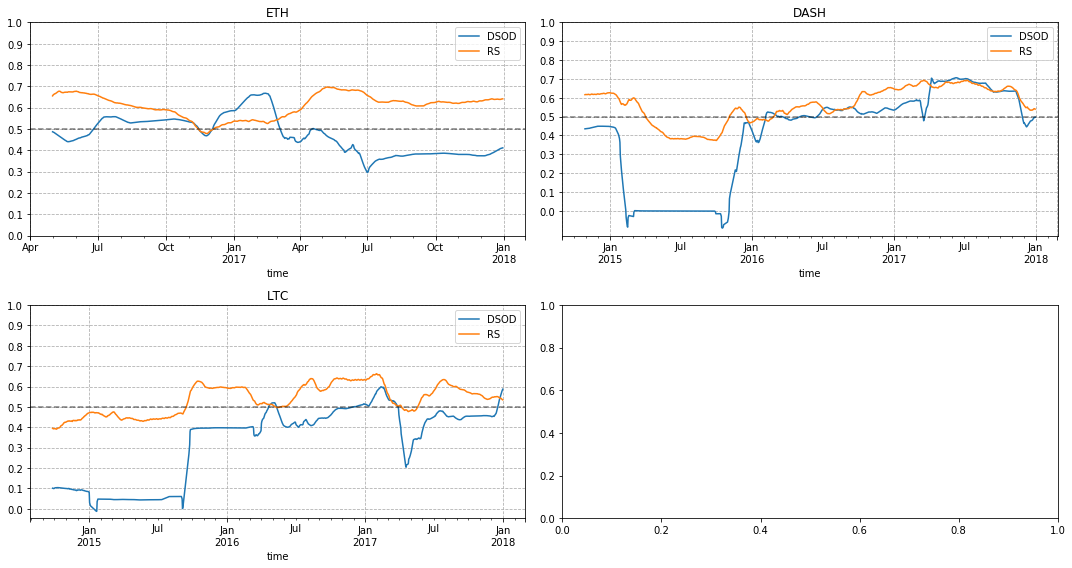

In [38]:
fig, axs = plt.subplots(2,2, figsize=(15,8))
for ax, coin in zip(axs.flat, coin_sym_list):
    roll_hurst[coin].rolling(20).mean().plot(ax=ax)
    ax.set_title(coin)
    ax.set_yticks(np.arange(11)/10)
    ax.grid(True, linestyle='--')
    ax.axhline(0.5, linestyle='--', color='k', alpha=0.5)
fig.tight_layout()

In [39]:
roll_hurst[::10].tail()

DASH                 ETH                 LTC          
                DSOD        RS      DSOD        RS      DSOD        RS
time                                                                  
2017-11-21  0.449091  0.511541  0.375634  0.639584  0.454159  0.543536
2017-12-01  0.456933  0.545984  0.378076  0.636859  0.435756  0.564556
2017-12-11  0.494765  0.529578  0.391933  0.640876  0.492454  0.541952
2017-12-21  0.457909  0.561385  0.416898  0.646611  0.610649  0.523105
2017-12-31  0.510587  0.505634  0.410169  0.646168  0.590117  0.518657

In [40]:
roll_hurst[::10].mean()

DASH  DSOD    0.412282
      RS      0.559767
ETH   DSOD    0.470345
      RS      0.610464
LTC   DSOD    0.328605
      RS      0.535169
dtype: float64

In [41]:
roll_hurst[::10].median()

DASH  DSOD    0.496858
      RS      0.567268
ETH   DSOD    0.472015
      RS      0.624193
LTC   DSOD    0.398707
      RS      0.544443
dtype: float64

In [42]:
roll_hurst[::10].mean(level=0, axis=1);

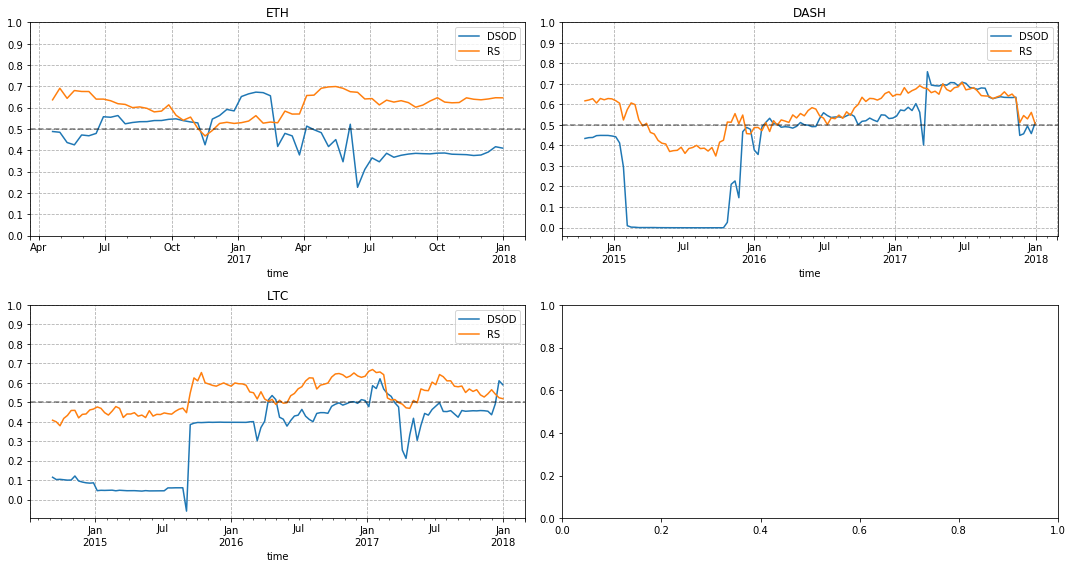

In [43]:
fig, axs = plt.subplots(2,2, figsize=(15,8))
for ax, coin in zip(axs.flat, coin_sym_list):
    roll_hurst[coin][::10].plot(ax=ax)
    ax.set_title(coin)
    ax.set_yticks(np.arange(11)/10)
    ax.grid(True, linestyle='--')
    ax.axhline(0.5, linestyle='--', color='k', alpha=0.5)
fig.tight_layout()

In [44]:
# rather decimate the series we aliasing the seies.
ma_roll_hurst = roll_hurst.rolling(10).mean()
ma_roll_hurst.tail()

DASH                 ETH                 LTC          
                DSOD        RS      DSOD        RS      DSOD        RS
time                                                                  
2017-12-27  0.498392  0.554863  0.417421  0.638947  0.600718  0.533022
2017-12-28  0.500085  0.551974  0.417680  0.639289  0.599631  0.529747
2017-12-29  0.501845  0.549053  0.417430  0.641424  0.598187  0.526552
2017-12-30  0.504279  0.546153  0.417216  0.643148  0.596148  0.525385
2017-12-31  0.509547  0.540578  0.416543  0.643104  0.594095  0.524940

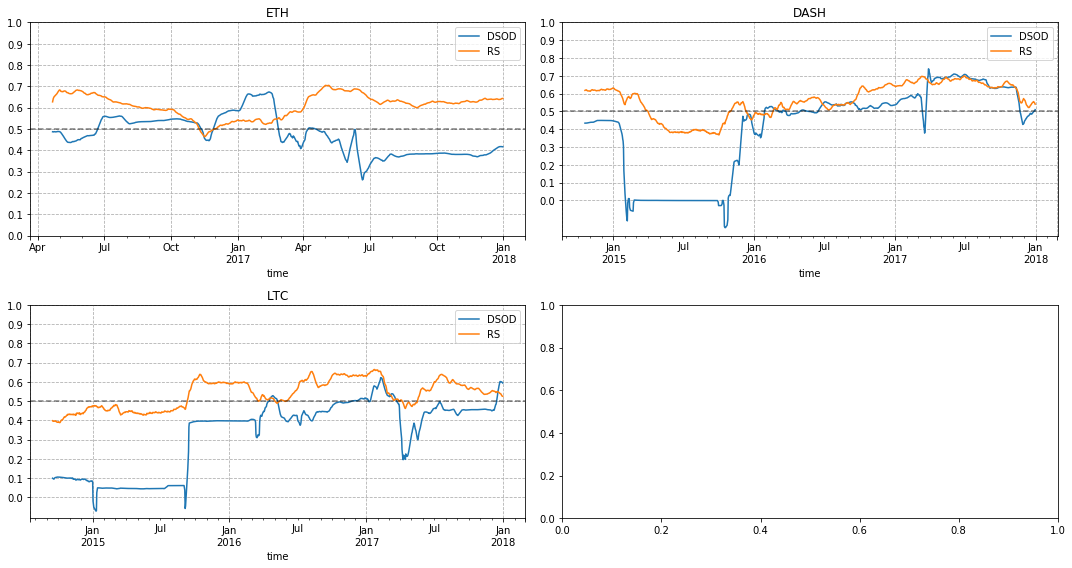

In [45]:
fig, axs = plt.subplots(2,2, figsize=(15,8))
for ax, coin in zip(axs.flat, coin_sym_list):
    roll_hurst[coin].rolling(10).mean().plot(ax=ax)
    ax.set_title(coin)
    ax.set_yticks(np.arange(11)/10)
    ax.grid(True, linestyle='--')
    ax.axhline(0.5, linestyle='--', color='k', alpha=0.5)
fig.tight_layout()

# REFERENCES

- Caporale, G. M., Gil-Alana, L., & Plastun, A. (2017). Persistence in the Cryptocurrency Market. https://www.sciencedirect.com/science/article/pii/S0275531917309200
- H.E. Hurst, 1951, “Long-term storage of reservoirs: an experimental study,” Transactions of the American Society of Civil Engineers, Vol. 116, pp. 770-799.
- Bo Qian, Khaled Rasheed, 2004, “Hurst Exponent and financial market predictability,” IASTED conference on “Financial Engineering and Applications”(FEA 2004), pp. 203-209,
- Mandelbrot, Benoit B., 2004, “The (Mis)Behavior of Markets, A Fractal View of Risk, Ruin and Reward,” Basic Books, 2004.
